In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

# Movie Recommender

## 1. Load Data

In [7]:
df_movies = pd.read_csv("data/movies.csv")
df_ratings = pd.read_csv("data/ratings.csv")

In [3]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
df_movies.shape

(9742, 2)

In [12]:
df_ratings["userId"].nunique()

610

In [8]:
df_movies = df_movies.drop(columns="genres")
df_ratings = df_ratings.drop(columns="timestamp")

## 2. Create a feature set
based on user rating for a movie

| movieid | user1 | user2 | user3 | ... | 
|---------|-------|-------|-------|-----|
| 1       | 0     | 2     | 4     | ..  |

In [14]:
df = df_movies.merge(df_ratings, how="left", on="movieId")

In [15]:
df.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),1.0,4.0
1,1,Toy Story (1995),5.0,4.0
2,1,Toy Story (1995),7.0,4.5
3,1,Toy Story (1995),15.0,2.5
4,1,Toy Story (1995),17.0,4.5


Calculate the no_of_ratings for each movie

In [20]:
df_no_of_ratings = (df.groupby("movieId")
                     .agg({"userId": "count"})
                     .rename(columns={"userId":"no_of_ratings"})
                     .reset_index())

In [25]:
df = df.merge(df_no_of_ratings, how="left", on="movieId")

In [26]:
df.head()

,movieId,title,userId,rating,no_of_ratings
0,1,Toy Story (1995),1.0,4.0,215
1,1,Toy Story (1995),5.0,4.0,215
2,1,Toy Story (1995),7.0,4.5,215
3,1,Toy Story (1995),15.0,2.5,215
4,1,Toy Story (1995),17.0,4.5,215


In [27]:
df_no_of_ratings.head()

,movieId,no_of_ratings
0,1,215
1,2,110
2,3,52
3,4,7
4,5,49


### 2.1 Filter out movies with number of ratings below a certain threshold

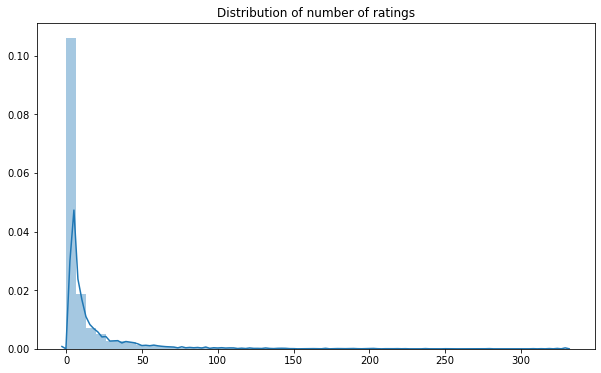

In [31]:
fig = plt.figure(figsize=(10,6))
sns.distplot(df_no_of_ratings.set_index("movieId"));
plt.title("Distribution of number of ratings");

In [32]:
df_no_of_ratings.describe()

,movieId,no_of_ratings
count,9742.000000,9742.000000
mean,42200.353623,10.350647
std,52160.494854,22.384729
min,1.000000,0.000000
25%,3248.250000,1.000000
50%,7300.000000,3.000000
75%,76232.000000,9.000000
max,193609.000000,329.000000


Set a lower threshold for no_of_ratings to be considered for recommendations

In [34]:
min_no_of_ratings = 5
movies = df[df["no_of_ratings"] >= 5].copy()

In [35]:
movies["movieId"].nunique()

3650

In [39]:
movie_features = movies.pivot_table(index="movieId",
                    columns="userId",
                    values="rating")

In [42]:
movie_features.head()

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,601.0,602.0,603.0,604.0,605.0,606.0,607.0,608.0,609.0,610.0
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
#filling null values so it works with sklearn
movie_features = movie_features.fillna(0)

In [44]:
movie_features.head()

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,601.0,602.0,603.0,604.0,605.0,606.0,607.0,608.0,609.0,610.0
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3. Modeling

## 3.1 More effective storage for sparse matrix

In [45]:
from scipy.sparse import csr_matrix

In [46]:
mat_movie_features = csr_matrix(movie_features)

In [47]:
mat_movie_features

<3650x610 sparse matrix of type '<class 'numpy.float64'>'
	with 90274 stored elements in Compressed Sparse Row format>

## 3.2 Train our model - KNN

In [48]:
model_knn = NearestNeighbors(metric="cosine",
                             algorithm="brute",
                             n_jobs=-1)
model_knn.fit(mat_movie_features)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1)

In [50]:
movie_features.head()

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,601.0,602.0,603.0,604.0,605.0,606.0,607.0,608.0,609.0,610.0
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
#make sure to use loc when accessing here because row and columns have same name
movie_features.loc[1].values.reshape(1, -1)

array([[4. , 0. , 0. , 0. , 4. , 0. , 4.5, 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 2.5, 0. , 4.5, 3.5, 4. , 0. , 3.5, 0. , 0. , 0. , 0. , 0. ,
        3. , 0. , 0. , 0. , 5. , 3. , 3. , 0. , 0. , 0. , 0. , 0. , 0. ,
        5. , 0. , 0. , 5. , 3. , 4. , 5. , 0. , 0. , 0. , 3. , 0. , 0. ,
        0. , 3. , 0. , 0. , 5. , 0. , 0. , 0. , 0. , 0. , 5. , 4. , 0. ,
        4. , 0. , 2.5, 0. , 0. , 5. , 0. , 4.5, 0. , 0. , 0.5, 0. , 4. ,
        0. , 0. , 0. , 2.5, 0. , 0. , 0. , 4. , 0. , 0. , 3. , 3. , 4. ,
        0. , 3. , 0. , 0. , 5. , 0. , 4.5, 0. , 0. , 0. , 0. , 4. , 0. ,
        0. , 0. , 4. , 0. , 0. , 0. , 0. , 3. , 0. , 0. , 0. , 0. , 0. ,
        0. , 3.5, 0. , 4. , 0. , 0. , 4. , 0. , 0. , 0. , 0. , 0. , 3. ,
        0. , 2. , 0. , 3. , 4. , 0. , 4. , 0. , 0. , 3. , 4. , 0. , 0. ,
        3.5, 5. , 0. , 0. , 0. , 0. , 0. , 5. , 0. , 2. , 0. , 3. , 4. ,
        0. , 0. , 4.5, 4. , 4. , 0. , 0. , 0. , 0. , 5. , 3.5, 0. , 4.5,
        0. , 5. , 0. , 0. , 0. , 0. , 0. , 5. , 4. 

In [63]:
#array 1 is cosine distance
#array 2 is positional index of movie (nearest neighbor)
model_knn.kneighbors(movie_features.loc[1].values.reshape(1, -1), n_neighbors=6)

(array([[0.        , 0.42739874, 0.4343632 , 0.43573831, 0.44261183,
         0.45290409]]),
 array([[   0, 1545,  306,  429,  169,  231]]))

In [65]:
#because we have the position index instead of the labeled index, we need to retrieve the correct movie id
#this is also because we removed movies with less than 5 reviews, so the positional index and movie id no
#longer match
movie_features.iloc[1545]

userId
1.0      0.0
2.0      0.0
3.0      0.0
4.0      0.0
5.0      0.0
        ... 
606.0    0.0
607.0    3.0
608.0    2.5
609.0    0.0
610.0    5.0
Name: 3114, Length: 610, dtype: float64

In [67]:
movie_features.head()

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,601.0,602.0,603.0,604.0,605.0,606.0,607.0,608.0,609.0,610.0
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
df_movies[df_movies["movieId"] == 3114]

,movieId,title
2355,3114,Toy Story 2 (1999)


In [72]:
movie_features.iloc[306]

userId
1.0      4.0
2.0      0.0
3.0      0.0
4.0      0.0
5.0      0.0
        ... 
606.0    2.5
607.0    4.0
608.0    3.0
609.0    3.0
610.0    5.0
Name: 480, Length: 610, dtype: float64

In [70]:
df_movies[df_movies["movieId"] == 480]

,movieId,title
418,480,Jurassic Park (1993)


In [73]:
df_movies[df_movies["movieId"] == movie_features.iloc[306].name ]

,movieId,title
418,480,Jurassic Park (1993)


Our kNN model returns a tuple of two 2-day arrays, containing distances and indeces of the nearest neighbors of the vector passed. In order for us to match the result with movieId or titles, we need to translate the output. 

# 4. Making our recommender more user-friendly

## 4.1 Translating recommendations to titles

In [82]:
#(2darray,) reduces it to 1d
#distances, (indeces,) = model_knn.kneighbors(movie_features.loc[1].values.reshape(1, -1), n_neighbors=6)
distances, indeces = model_knn.kneighbors(movie_features.loc[1].values.reshape(1, -1), n_neighbors=6)

In [83]:
distances

array([[0.        , 0.42739874, 0.4343632 , 0.43573831, 0.44261183,
        0.45290409]])

In [84]:
indeces

array([   0, 1545,  306,  429,  169,  231])

### Create a mapping between the movieId and the title

In [81]:
movie_list = movies[["movieId", "title"]].drop_duplicates().set_index("movieId")

The `indeces` array contains the positional indecies of the movies in the initial dataset used for training (`movie_features`).

In [88]:
j = 0
for i in indeces.flatten():
    movie = movie_list.iloc[i, 0]
    if j == 0:
        print(f"Recommendations for {movie}")
        print("-----------------------------\n")
    else:
        print(f"{j}: {movie}")
    j += 1


Recommendations for Toy Story (1995)
-----------------------------

1: Toy Story 2 (1999)
2: Jurassic Park (1993)
3: Independence Day (a.k.a. ID4) (1996)
4: Star Wars: Episode IV - A New Hope (1977)
5: Forrest Gump (1994)


In [89]:
indeces.flatten()

array([   0, 1545,  306,  429,  169,  231])

In [90]:
distances.flatten()

array([0.        , 0.42739874, 0.4343632 , 0.43573831, 0.44261183,
       0.45290409])

In [92]:
list(zip(indeces.flatten(), distances.flatten()))

[(0, 0.0),
 (1545, 0.4273987396802844),
 (306, 0.4343631959138433),
 (429, 0.43573830647233425),
 (169, 0.4426118294200634),
 (231, 0.4529040920598262)]

In [93]:
def print_recommendations(knn_output):
    distances, indeces = knn_output
    j = 0
    for i, distance in list(zip(indeces.flatten(), distances.flatten())):
        movie = movie_list.iloc[i, 0]
        if j == 0:
            print(f"Recommendations for {movie}")
            print("-----------------------------\n")
        else:
            print(f"{j}: {movie}, with distance {round(distance, 2)}")
        j += 1

In [94]:
print_recommendations(model_knn.kneighbors(movie_features.loc[1].values.reshape(1, -1), n_neighbors=6))

Recommendations for Toy Story (1995)
-----------------------------

1: Toy Story 2 (1999), with distance 0.43
2: Jurassic Park (1993), with distance 0.43
3: Independence Day (a.k.a. ID4) (1996), with distance 0.44
4: Star Wars: Episode IV - A New Hope (1977), with distance 0.44
5: Forrest Gump (1994), with distance 0.45


In [95]:
movie_list

,title
movieId,
1,Toy Story (1995)
2,Jumanji (1995)
3,Grumpier Old Men (1995)
4,Waiting to Exhale (1995)
5,Father of the Bride Part II (1995)
...,...
180031,The Shape of Water (2017)
180985,The Greatest Showman (2017)
183897,Isle of Dogs (2018)


In [96]:
print_recommendations(model_knn.kneighbors(movie_features.loc[183897].values.reshape(1, -1), n_neighbors=6))

Recommendations for Isle of Dogs (2018)
-----------------------------

1: The Shape of Water (2017), with distance 0.46
2: Three Billboards Outside Ebbing, Missouri (2017), with distance 0.55
3: The Greatest Showman (2017), with distance 0.56
4: Hacksaw Ridge (2016), with distance 0.64
5: Creed (2015), with distance 0.66


## 4.2 Translating movieIds to movie-rating-vectors

In [98]:
def movieid_to_vector(movie_id):
    return movie_features.loc[movie_id].values.reshape(1, -1)

In [100]:
print_recommendations(model_knn.kneighbors(movieid_to_vector(3), 6))

Recommendations for Grumpier Old Men (1995)
-----------------------------

1: Grumpy Old Men (1993), with distance 0.55
2: Striptease (1996), with distance 0.55
3: Nutty Professor, The (1996), with distance 0.55
4: Twister (1996), with distance 0.56
5: Father of the Bride Part II (1995), with distance 0.58


In [101]:
def recommender(movie_id, n=5):
    recs = n+1
    print_recommendations(model_knn.kneighbors(movieid_to_vector(movie_id), recs))

In [105]:
movie_list[700:720]

,title
movieId,
1272,Patton (1970)
1273,Down by Law (1986)
1274,Akira (1988)
1275,Highlander (1986)
1276,Cool Hand Luke (1967)
1277,Cyrano de Bergerac (1990)
1278,Young Frankenstein (1974)
1279,Night on Earth (1991)
1280,Raise the Red Lantern (Da hong deng long gao g...


In [103]:
recommender(110)

Recommendations for Braveheart (1995)
-----------------------------

1: Jurassic Park (1993), with distance 0.33
2: Terminator 2: Judgment Day (1991), with distance 0.34
3: Fugitive, The (1993), with distance 0.35
4: Forrest Gump (1994), with distance 0.36
5: Pulp Fiction (1994), with distance 0.37


In [106]:
recommender(1288)

Recommendations for This Is Spinal Tap (1984)
-----------------------------

1: Monty Python and the Holy Grail (1975), with distance 0.48
2: Fish Called Wanda, A (1988), with distance 0.49
3: Raising Arizona (1987), with distance 0.5
4: Ferris Bueller's Day Off (1986), with distance 0.51
5: Beetlejuice (1988), with distance 0.52


## 4.3 Allow title queries as input 
Extend on the previous example to allow input as title instead of movieId. We are building a super simple search engine. 

We need a flexible mapping from title to movie id. 

In [108]:
movie_list.head()

,title
movieId,
1,Toy Story (1995)
2,Jumanji (1995)
3,Grumpier Old Men (1995)
4,Waiting to Exhale (1995)
5,Father of the Bride Part II (1995)


In [112]:
movie_index = {title: idx for idx, title in movie_list.to_dict()["title"].items()}

### Quick intro to fuzzy string matching so we can introduct tolerance to search queries

In [118]:
from fuzzywuzzy import fuzz

In [119]:
fuzz.ratio("Hello", "Hello")

100

In [120]:
fuzz.ratio("Hillo", "Hello")

80

In [121]:
fuzz.ratio("father of the bride", "Father of the Bride Part II (1995)")

64

In [122]:
fuzz.ratio("grumpy old men", "Father of the Bride Part II (1995)")

21

In [123]:
fuzz.ratio("father of the bride".lower(), "Father of the Bride Part II (1995)".lower())

72

In [124]:
fuzz.ratio("father of the bride".lower(), "Father of the Bride Part II".lower())

83

In [113]:
import re

In [116]:
t = "Grumpier Old Men (1995)"
t_pattern = r"(.*)\s\(\d{4}\)$"
extr_t, = re.findall(t_pattern, t)

In [117]:
extr_t

'Grumpier Old Men'

In [128]:
fav_movie = "drive"

In [129]:
matches = []
for title, movie_id in movie_index.items():
    #remove the year
    title_pattern = r"(.*)\s\(\d{4}\)$"
    extr_t, = re.findall(title_pattern, title)
    
    #compute ratio and remove case sensitivity
    ratio = fuzz.ratio(extr_t.lower(), fav_movie.lower())
    
    #add all matches to list with ratio > 60
    if ratio >= 60:
        matches.append((title, movie_id, ratio))
    
    


In [130]:
matches

[('Taxi Driver (1976)', 111, 62),
 ('Dave (1993)', 440, 67),
 ('Eddie (1996)', 656, 60),
 ('Diva (1981)', 1264, 67),
 ('Alive (1993)', 3250, 60),
 ('Diner (1982)', 3543, 60),
 ('Driven (2001)', 4265, 91),
 ('Drumline (2002)', 5941, 62),
 ('Prime (2005)', 39449, 60),
 ('Drive (2011)', 88129, 100),
 ('Brave (2012)', 95167, 60),
 ('Dredd (2012)', 96737, 60),
 ('Baby Driver (2017)', 171763, 62),
 ('Wind River (2017)', 175569, 67)]

In [134]:
sorted(matches, key=lambda x: x[2], reverse=True)[0][1]

88129

In [135]:
recommender(88129)

Recommendations for Drive (2011)
-----------------------------

1: Cabin in the Woods, The (2012), with distance 0.42
2: Seven Psychopaths (2012), with distance 0.44
3: Up in the Air (2009), with distance 0.44
4: Prometheus (2012), with distance 0.44
5: In Bruges (2008), with distance 0.45


In [136]:
def find_movie_id(query): 
    matches = []
    for title, movie_id in movie_index.items():
        #remove the year
        title_pattern = r"(.*)\s\(\d{4}\)$"
        extr_t, = re.findall(title_pattern, title)
        
        #compute ratio and remove case sensitivity
        ratio = fuzz.ratio(extr_t.lower(), query.lower())
        
        #add all matches to list with ratio > 60
        if ratio >= 60:
            matches.append((title, movie_id, ratio))
    if len(matches)==0:
        print("Sorry, couldn't find your movie. Try again!")
    
    return sorted(matches, key=lambda x: x[2], reverse=True)[0][1]    

In [137]:
recommender(find_movie_id("drive"))

Recommendations for Drive (2011)
-----------------------------

1: Cabin in the Woods, The (2012), with distance 0.42
2: Seven Psychopaths (2012), with distance 0.44
3: Up in the Air (2009), with distance 0.44
4: Prometheus (2012), with distance 0.44
5: In Bruges (2008), with distance 0.45


In [138]:
def recommender_final(movie_title, n=5):
    movie_id = find_movie_id(movie_title)
    if movie_id is None:
        return 
    recs = n + 1
    print_recommendations(model_knn.kneighbors(movieid_to_vector(movie_id), recs))

In [140]:
recommender_final("zootopia")

Recommendations for Zootopia (2016)
-----------------------------

1: Inside Out (2015), with distance 0.4
2: Deadpool (2016), with distance 0.42
3: Big Hero 6 (2014), with distance 0.43
4: Star Wars: Episode VII - The Force Awakens (2015), with distance 0.43
5: Guardians of the Galaxy (2014), with distance 0.44


In [146]:
recommender_final("lemon weapon")

Recommendations for Lethal Weapon (1987)
-----------------------------

1: RoboCop (1987), with distance 0.34
2: Lethal Weapon 2 (1989), with distance 0.39
3: Indiana Jones and the Temple of Doom (1984), with distance 0.4
4: Escape from New York (1981), with distance 0.42
5: Ghostbusters (a.k.a. Ghost Busters) (1984), with distance 0.44
